# VQE using QNG

This is a short tutorial on how to implement VQE using quantum natural gradient descent.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

import pennylane as qml
from pennylane import expval

To run and optimize quantum circuits using Pennylane, we first need to specify a device (simulator or hardware).

In [2]:
dev = qml.device("default.qubit", wires=2)

The Hamiltonian-of-interest is: 

$$
\hat{H} = \alpha (I \otimes Z + Z \otimes I) + \beta (X \otimes X) 
$$

where $\alpha = 0.4$ and $\beta = 0.2$.

In [3]:
alpha = 0.4
beta = 0.2

coeffs = [alpha, alpha, beta]
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

Our ansatz is a simple two-qubit circuit composed of Y rotations and a CNOT gate. There are 4 parameters in total.

In [4]:
def circuit(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    
    qml.CNOT(wires=wires)
    
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])

We are going to create a collection of QNodes (quantum circuits) that can be executed to compute the expectation value of the energy.

In [5]:
qnodes = qml.map(circuit, obs_list, dev, measure='expval')
energy_expval = qml.dot([alpha, alpha, beta], qnodes)

Now to set up the optimizer, we will test both vanilla and natural gradient descent methods. First, we set the stepsize, number of iterations, and initial parameters.

In [6]:
step_size = 0.2
max_iterations = 200

initial_params = [0.432, -0.123, 0.543, 0.233]

conv_tol = 1e-06

print_freq = 10

We start with the vanilla gradient descent:

In [7]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = initial_params
prev_energy = energy_expval(params)
gd_energies = [prev_energy]

for n in range(max_iterations):
    
    # Take step
    params = opt.step(energy_expval, params)
    
    # Compute energy
    energy = energy_expval(params)
    gd_energies.append(energy)
    
    # Compute difference wrt previous energy (to test termination criterion)
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        gd_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', gd_nsteps)

Iteration = 0,  Energy = 0.75401731 Ha,  Convergence parameter = 0.01193383 Ha
Iteration = 10,  Energy = 0.35063698 Ha,  Convergence parameter = 0.07686998 Ha
Iteration = 20,  Energy = -0.38174131 Ha,  Convergence parameter = 0.03587287 Ha
Iteration = 30,  Energy = -0.55606652 Ha,  Convergence parameter = 0.01167742 Ha
Iteration = 40,  Energy = -0.65010718 Ha,  Convergence parameter = 0.00788183 Ha
Iteration = 50,  Energy = -0.71513211 Ha,  Convergence parameter = 0.00552454 Ha
Iteration = 60,  Energy = -0.76101414 Ha,  Convergence parameter = 0.00388703 Ha
Iteration = 70,  Energy = -0.79214039 Ha,  Convergence parameter = 0.00250037 Ha
Iteration = 80,  Energy = -0.81045251 Ha,  Convergence parameter = 0.00133352 Ha
Iteration = 90,  Energy = -0.81926687 Ha,  Convergence parameter = 0.00057920 Ha
Iteration = 100,  Energy = -0.82279823 Ha,  Convergence parameter = 0.00021453 Ha
Iteration = 110,  Energy = -0.82403996 Ha,  Convergence parameter = 0.00007174 Ha
Iteration = 120,  Energy = -0

Now we look at natural gradient descent. We first look at the block-diagonal approximation then diagonal approximation.

In [8]:
qnodes[0].metric_tensor([initial_params], diag_approx=False)

array([[ 0.25      ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.25      ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.25      , -0.10388118],
       [ 0.        ,  0.        , -0.10388118,  0.25      ]])

In [9]:
params = initial_params
prev_energy = energy_expval(params)
qngd_energies_block_diag = [prev_energy]

for n in range(max_iterations):
    
    grad_cost = qml.grad(energy_expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params])),
                                         grad_at_point)

    energy = energy_expval(params)
    qngd_energies_block_diag.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        qngd_block_diag_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', qngd_block_diag_nsteps)

Iteration = 0,  Energy = 0.71282889 Ha,  Convergence parameter = 0.05312225 Ha
Iteration = 10,  Energy = -0.82286488 Ha,  Convergence parameter = 0.00105422 Ha
Iteration = 20,  Energy = -0.82460117 Ha,  Convergence parameter = 0.00001157 Ha

Final convergence parameter = 0.00000074 Ha
Final value of the ground-state energy = -0.82461986 Ha

Final circuit parameters =  [0.8780503  1.8896833  2.28876504 1.36466678]
Number of iterations = 
 26


Lastly, we look at the diagonal approximation.

In [10]:
qnodes[0].metric_tensor([initial_params], diag_approx=True)

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [11]:
params = initial_params
prev_energy = energy_expval(params)
qngd_energies_diag = [prev_energy]

for n in range(max_iterations):
    
    grad_cost = qml.grad(energy_expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params], diag_approx=True)),
                                         grad_at_point)

    energy = energy_expval(params)
    qngd_energies_diag.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        qngd_diag_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', qngd_diag_nsteps)

Iteration = 0,  Energy = 0.71108726 Ha,  Convergence parameter = 0.05486387 Ha
Iteration = 10,  Energy = -0.62669027 Ha,  Convergence parameter = 0.03838078 Ha
Iteration = 20,  Energy = -0.80883614 Ha,  Convergence parameter = 0.00685900 Ha
Iteration = 30,  Energy = -0.82448381 Ha,  Convergence parameter = 0.00009492 Ha

Final convergence parameter = 0.00000078 Ha
Final value of the ground-state energy = -0.82462004 Ha

Final circuit parameters =  [2.13237029 1.86022848 0.99082984 1.72607803]
Number of iterations = 
 39


In [12]:
def compute_metric_tensor(p):
    metric = np.array([[0.25, 0, 0.25*np.sin(p[1]), 0],
                       [0, 0.25, 0, 0.25*np.cos(params[0])],
                       [0.25*np.sin(p[1]), 0, 0.25, -0.25*np.cos(p[1])*np.sin(p[0])],
                       [0, 0.25*np.cos(p[0]), -0.25*np.cos(p[1])*np.sin(p[0]), 0.25]])
    return metric

In [13]:
compute_metric_tensor(initial_params)

array([[ 0.25      ,  0.        , -0.03067252,  0.        ],
       [ 0.        ,  0.25      ,  0.        , -0.13312977],
       [-0.03067252,  0.        ,  0.25      , -0.10388118],
       [ 0.        ,  0.22703255, -0.10388118,  0.25      ]])

In [14]:
params = initial_params
prev_energy = energy_expval(params)
qngd_energies_exact = [prev_energy]

for n in range(max_iterations):
    
    grad_cost = qml.grad(energy_expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(compute_metric_tensor(params)),
                                         grad_at_point)

    energy = energy_expval(params)
    qngd_energies_exact.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        qngd_exact_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', qngd_exact_nsteps)

Iteration = 0,  Energy = 0.70543187 Ha,  Convergence parameter = 0.06051926 Ha
Iteration = 10,  Energy = -0.80300925 Ha,  Convergence parameter = 0.01554603 Ha
Iteration = 20,  Energy = -0.82454926 Ha,  Convergence parameter = 0.00005583 Ha

Final convergence parameter = 0.00000100 Ha
Final value of the ground-state energy = -0.82461984 Ha

Final circuit parameters =  [1.91852089 1.8317202  1.21422325 1.6592019 ]
Number of iterations = 
 27


Try plotting the results.

In [15]:
exact_energy = -np.sqrt(4*alpha**2 + beta**2)

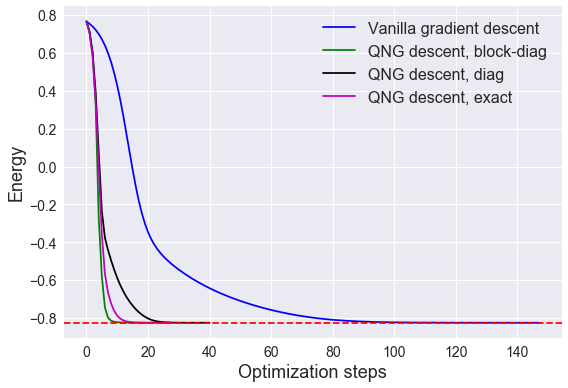

In [16]:
plt.style.use("seaborn")
fig = plt.figure()
plt.plot(gd_energies, "b", label="Vanilla gradient descent")
plt.plot(qngd_energies_block_diag, "g", label="QNG descent, block-diag")
plt.plot(qngd_energies_diag, "k", label="QNG descent, diag")
plt.plot(qngd_energies_exact, "m", label="QNG descent, exact")

plt.axhline(y=exact_energy, color='r', linestyle='--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)
plt.legend(fontsize=16)

plt.tight_layout()

In [20]:
print('N steps')
print('=======\n')

print('Vanilla GD.      : {0:d}'.format(gd_nsteps))
print('QNGD, block-diag : {0:d}'.format(qngd_block_diag_nsteps))
print('QNGD, diag       : {0:d}'.format(qngd_diag_nsteps))
print('QNGD, exact      : {0:d}'.format(qngd_exact_nsteps))

N steps

Vanilla GD.      : 146
QNGD, block-diag : 26
QNGD, diag       : 39
QNGD, exact      : 27


Convergence looks good! How about energy error?

In [21]:
print('Energy error')
print('============\n')

print('Vanilla GD.      : {0:.10f}'.format(np.min(gd_energies) - exact_energy))
print('QNGD, block-diag : {0:.10f}'.format(np.min(qngd_energies_block_diag) - exact_energy))
print('QNGD, diag       : {0:.10f}'.format(np.min(qngd_energies_diag) - exact_energy))
print('QNGD, exact      : {0:.10f}'.format(np.min(qngd_energies_exact) - exact_energy))

Energy error

Vanilla GD.      : 0.0000076456
QNGD, block-diag : 0.0000012633
QNGD, diag       : 0.0000010873
QNGD, exact      : 0.0000012844
